# Semantic Segmentation

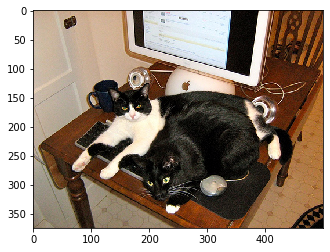

torch.Size([1, 21, 375, 500])
[ 0  8 11 20]


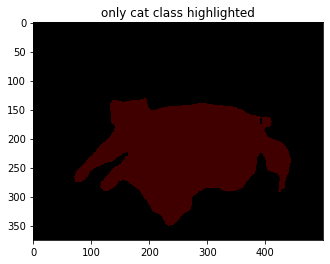

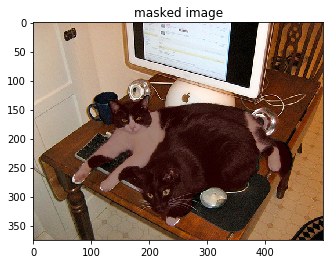

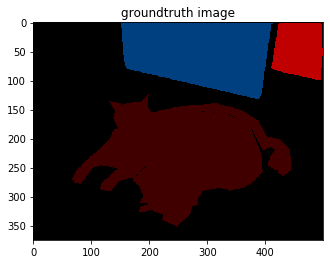

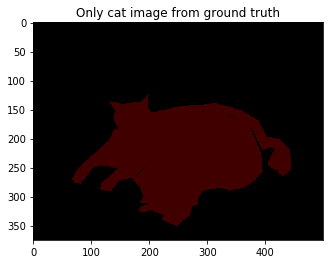

IOU= 0.8947681584427728


In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import models
import numpy as np
import torchvision.transforms as T
import cv2


def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  l=nc
  idx = image == l
  r[idx] = label_colors[l, 0]
  g[idx] = label_colors[l, 1]
  b [idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  #print(rgb)
  #print(rgb.shape)
  return rgb


def apply_mask(im, im_pred):
    """
    Overlays the predicted class labels onto an image using the alpha channel.
    This function assumes that the background label is the black color.
    This function is provided as an inspiration for the masking function you should write.
    """
    r_channel, g_channel, b_channel = cv2.split(im_pred)
    r_channel=g_channel+b_channel+r_channel
    g_channel=np.ones(g_channel.shape, dtype=g_channel.dtype)
    b_channel=np.ones(b_channel.shape, dtype=b_channel.dtype)
    alpha_channel = 127 * np.ones(b_channel.shape, dtype=b_channel.dtype)
    # Make background pixels fully transparent
    alpha_channel -= 127 * np.all(im_pred == np.array([0, 0, 0]), axis=2).astype(b_channel.dtype)
    im_pred = cv2.merge((r_channel, g_channel, b_channel, alpha_channel))
    mask = Image.fromarray(im_pred, mode='RGBA')
    masked_img = Image.fromarray(im)
    masked_img.paste(mask, box=None, mask=mask)
    return np.array(masked_img)

# define the model
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()

# load an image
img = Image.open('./RAMASUBA@TCD.IE.png')
plt.imshow(img); plt.show()

# transform the image
trf = T.Compose([T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
inp = trf(img).unsqueeze(0)

# pass the input through the net
out = fcn(inp)['out']
print (out.shape)

# calculate labels
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (np.unique(om))

# show segmentation output
rgb = decode_segmap(om,8)
plt.title('only cat class highlighted')
plt.imshow(rgb); plt.show()

img=np.array(img)



mask=apply_mask(img,rgb)
plt.title('masked image')
plt.imshow(mask); plt.show()
j = Image.fromarray(mask)
j.save('ramasuba@tcd.ie_predicted.png')

ground_truth = Image.open('./RAMASUBA@TCD.IE_mask.png')
ground_truth_array = np.array(ground_truth)
plt.title('groundtruth image')
plt.imshow(ground_truth);plt.show()
pixels=ground_truth.load()
#Getting only the cat from the ground truth image
for i in range (ground_truth_array.shape[1]):
    for j in range (ground_truth_array.shape[0]):
         if not (pixels[i,j]==(64, 0, 0)): #As the class is 8,this has pixel value 64,0,0
             pixels[i,j]=(0,0,0)
plt.title('Only cat image from ground truth')
plt.imshow(ground_truth); plt.show() 

numer=np.sum(np.logical_and(rgb,ground_truth))
denom=np.sum(np.logical_or(rgb,ground_truth))
IOU=numer/denom

print('IOU=',IOU)
